# Objective
* 탐지 미탐지 sequence 에서 일정 구간 추출하기

In [1]:
%load_ext autoreload
%autoreload 2

In [118]:
import cv2
import logging
import matplotlib.pyplot as plt
import numpy as np
import random

np.set_printoptions(precision=1)

In [76]:
def smooth(object_status):
    wlen = min(5, len(object_status))
    T = 1. / wlen
    w = np.ones(wlen)
    status = np.convolve(w / w.sum(), object_status, mode='same')
    
    return status, T

In [114]:
# obj_status=[0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,1,0,0,1,1,1,1,0,0,0,0,0,]
pattern1=[0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,1,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0]
pattern0=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
pattern2=[0,0,0]
pattern3=[0,0,0,0,1,0,1,1,1,1,0,1,0,0]
pattern4=[0,0,0,0,0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0]
pattern = [ random.randint(0, 1) for x in range(random.randint(5, 100)) ]
pattern

[0.  0.  0.2 0.2 0.4 0.6 0.8 0.8 0.8 0.8 0.6 0.4 0.2 0.2]


[0.4 0.6 0.6 0.8 0.6 0.4 0.4 0.6 0.4 0.6 0.8 0.8 0.8 0.8 0.8 0.6 0.4 0.2
 0.2 0.2 0.4 0.4 0.4 0.6 0.4 0.2 0.2 0.2 0.2 0.2 0.2 0.4 0.6 0.4 0.6 0.8
 0.8 0.8 0.8 0.6 0.6 0.4 0.2 0.4 0.4 0.4 0.6 0.6 0.4 0.6 0.6 0.4 0.6 0.6
 0.4]
frame_margin : 6
Trigger = False
연속적으로 T 이상인 구간 0 54
margin 을 추가한 연속 구간 0, None
0, 54, 0, None
None included
object_status : [0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1]


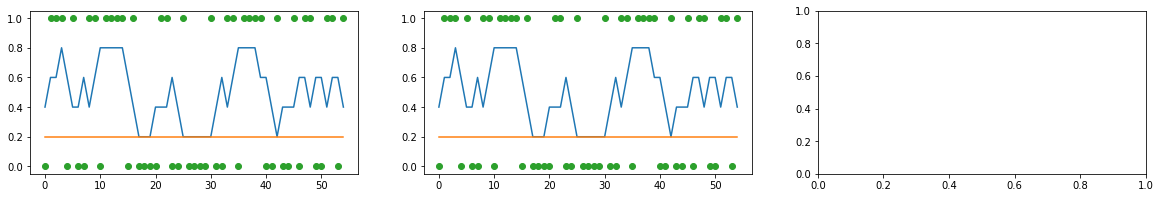

In [126]:
object_status=pattern

status, T=smooth(object_status)
print(status)
n=len(status)

true_region_start=3
true_region_end=29
frame_margin = int(round(1./T + 0.5))
print(f'frame_margin : {frame_margin}')

fig, ax=plt.subplots(1, 3, figsize=(20, 3))
x=range(n)
ax[0].plot(x, status)
ax[0].plot(x, np.ones(n)*T)
ax[0].plot(x, np.array(object_status), 'o')

# 언제 trigger 할 것인가?
# 마지막이 0이고 왼쪽으로 T만큼 0이 반복되면 trigger
idx0=np.argwhere(status[::-1] < T)
trigger=np.sum(idx0[0:frame_margin])==np.sum(range(frame_margin))
print(f'Trigger = {trigger}')

s0=None
e0=None
# 1st step : 연속적으로 T 이상인 index를 찾자
idx=np.argwhere(status >= T)
if len(idx) == 0:
    del object_status[0:n-frame_margin]
    print(f'연속적으로 T 이상인 구간이 없음 {object_status}')
else:
    s0=int(idx[0])
    e0=int(idx[-1])
    print(f'연속적으로 T 이상인 구간 {s0} {e0}')

s1=None
e1=None
if s0 is not None and e0 is not None:
    # 2nd step : s0, e0 에서 frame_margin 만큼 확장하자
    # 2-1 : s0-frame_margin >= 0   # s1 = s0-frame_margin
    # 2-2 : s0-frame_margin < 0    # s1 = max(0, s0-frame_margin)
    s1 = max(0, s0-frame_margin)
    # 2-3 : e0+frame_margin < n    # e1 = e0+frame_margin
    if e0+frame_margin < n:
        e1 = e0+frame_margin
    else:
    # 2-4 ; e0+frame_margin >= n    # e1 = None (다음 state 가 1이될 가능성이 있으므로 기다린다)
        e1 = None
    
print(f'margin 을 추가한 연속 구간 {s1}, {e1}')

ax[0].plot([s1, e1], [1, 1], 'r')

object_sequence=None
# step#3 : 0 부터 e1 까지 지운다
# if len([x is None for x in [s0, e0, s1, e1]])==0:
print(f'{s0}, {e0}, {s1}, {e1}')
if [s0, e0, s1, e1].count(None) < 1:
#     object_sequence=display_data[s1:e1]
    object_sequence=status[s1:e1]
#     del object_status[e1:]
    del object_status[:e1]
#     status = np.delete(status, np.s_[e1:])
#     status = np.delete(status, np.s_[:s1])
    status = np.delete(status, np.s_[:e1])
else:
    print(f'None included')

n=len(status)
x=range(n)
ax[1].plot(x, status)
ax[1].plot(x, np.ones(n)*T)
ax[1].plot(x, np.array(object_status), 'o')
print(f'object_status : {object_status}')

if object_sequence is not None:
    n=len(object_sequence)
    x=range(n)
    ax[2].plot(x, object_sequence)
    # ax[2].plot(x, np.ones(n)*T)
    # ax[2].plot(x, np.array(object_status), 'o')
    print(f'object_status : {object_status}')
